In [22]:
using JuMP,Ipopt, LinearAlgebra

In [23]:
#model initialization

In [24]:
mod = Model( optimizer_with_attributes( Ipopt.Optimizer , "max_iter" => 1000))

A JuMP Model
Feasibility problem with:
Variables: 0
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: Ipopt

In [25]:
begin
    const c1 = 1; # Spring constant
    const c2 = 1;
    const c3 = 1;
    const m1 = 5.0; # Mass
    const m2 = 5.0;
    const m3 = 5.0;
    const m4 = 5.0;

end

5.0

In [26]:
A = [0 0 0 0 1 0 0 0; 0 0 0 0 0 1 0 0 ; 0 0 0 0 0 0 1 0 ; 0 0 0 0 0 0 0 1 ; -c1/m1 c1/m1 0 0 0 0 0 0 ; c1/m2 -(c2+c1)/m2 c2/m2 0 0 0 0 0 ; 0 c2/m3 -(c2+c3)/m3 c3/m3 0 0 0 0 ; 0 0 c3/m4 -c3/m4 0 0 0 0]


8×8 Matrix{Float64}:
  0.0   0.0   0.0   0.0  1.0  0.0  0.0  0.0
  0.0   0.0   0.0   0.0  0.0  1.0  0.0  0.0
  0.0   0.0   0.0   0.0  0.0  0.0  1.0  0.0
  0.0   0.0   0.0   0.0  0.0  0.0  0.0  1.0
 -0.2   0.2   0.0   0.0  0.0  0.0  0.0  0.0
  0.2  -0.4   0.2   0.0  0.0  0.0  0.0  0.0
  0.0   0.2  -0.4   0.2  0.0  0.0  0.0  0.0
  0.0   0.0   0.2  -0.2  0.0  0.0  0.0  0.0

In [27]:
B = [0 0 0 0 ; 0 0 0 0 ; 0 0 0 0; 0 0 0 0; 1/m1 0 0 0 ; 0 1/m2 0 0; 0 0 1/m3 0 ; 0 0 0 1/m4] # Input matrix

8×4 Matrix{Float64}:
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.2  0.0  0.0  0.0
 0.0  0.2  0.0  0.0
 0.0  0.0  0.2  0.0
 0.0  0.0  0.0  0.2

In [28]:
C = [1 0 0 0 0 0 0 0 ; 0 1 0 0 0 0 0 0 ; 0 0 1 0 0 0 0 0; 0 0 0 1 0 0 0 0 ; ] # Output matrix

4×8 Matrix{Int64}:
 1  0  0  0  0  0  0  0
 0  1  0  0  0  0  0  0
 0  0  1  0  0  0  0  0
 0  0  0  1  0  0  0  0

In [29]:
Nx = size(A)[1]
Nu = size(B)[2]

4

In [30]:
# Input constraints
umin = -10.0;
umax = 10.0;

In [31]:
K = 200; # Number of time steps
x0 = zeros(8); # Initial conditions; also possible: x0 = 3*rand(4); 

In [32]:
∆T = 0.1
Tf = K * ∆T; # Final time

In [33]:
Q = 100 * Diagonal(ones(Nx))    # Weighing matrix for states / error: e' Q e or x' Q x
R = Diagonal(ones(Nu))  

4×4 Diagonal{Float64, Vector{Float64}}:
 1.0   ⋅    ⋅    ⋅ 
  ⋅   1.0   ⋅    ⋅ 
  ⋅    ⋅   1.0   ⋅ 
  ⋅    ⋅    ⋅   1.0

In [34]:
ref = [2.0, 4.0, 0.0, 0.0,  0.0, 0.0, 0.0, 0.0] 

8-element Vector{Float64}:
 2.0
 4.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [35]:
@variable(mod, umin <= u[1:4, 1:K-1] <= umax) # Control signals

4×199 Matrix{VariableRef}:
 u[1,1]  u[1,2]  u[1,3]  u[1,4]  u[1,5]  …  u[1,197]  u[1,198]  u[1,199]
 u[2,1]  u[2,2]  u[2,3]  u[2,4]  u[2,5]     u[2,197]  u[2,198]  u[2,199]
 u[3,1]  u[3,2]  u[3,3]  u[3,4]  u[3,5]     u[3,197]  u[3,198]  u[3,199]
 u[4,1]  u[4,2]  u[4,3]  u[4,4]  u[4,5]     u[4,197]  u[4,198]  u[4,199]

In [36]:
@variable(mod, x[1:Nx, 1:K])            # States x
@constraint(mod, x[1:Nx, 1] .== x0 )    # Initial values
@variable(mod, e[1:Nx, 1:K] )           # Error between reference and states
@constraint(mod,  e[1:Nx, 1:K] .== ref[1:Nx] - x[1:Nx, 1:K])

8×200 Matrix{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.EqualTo{Float64}}, ScalarShape}}:
 x[1,1] + e[1,1] == 2.0  …  x[1,200] + e[1,200] == 2.0
 x[2,1] + e[2,1] == 4.0     x[2,200] + e[2,200] == 4.0
 x[3,1] + e[3,1] == 0.0     x[3,200] + e[3,200] == 0.0
 x[4,1] + e[4,1] == 0.0     x[4,200] + e[4,200] == 0.0
 x[5,1] + e[5,1] == 0.0     x[5,200] + e[5,200] == 0.0
 x[6,1] + e[6,1] == 0.0  …  x[6,200] + e[6,200] == 0.0
 x[7,1] + e[7,1] == 0.0     x[7,200] + e[7,200] == 0.0
 x[8,1] + e[8,1] == 0.0     x[8,200] + e[8,200] == 0.0

In [37]:
for k = 1: K-1
    @constraint(mod, x[:, k+1] .== x[:, k] + ∆T *(A * x[:,k] + B * u[:,k] )) # Discrete-time system dynamics 
end


In [38]:
J = @NLexpression(mod, 0.5 * ∆T * sum( Q[1,1]*e[1,k]^2 + Q[2,2]*e[2,k]^2 + Q[3,3]*e[3,k]^2 + Q[4,4]*e[4,k]^2 + Q[5,5]*e[5,k]^2 + Q[6,6]*e[6,k]^2 + Q[7,7]*e[7,k]^2 + Q[8,8]*e[8,k]^2 + R[1,1]*u[1,i]^2 + R[2,2]*u[2,i]^2 + R[3,3]*u[3,i]^2 + R[4,4]*u[4,i]^2  for k=1:K, i=1:K-1 ))
@NLobjective( mod, Min, J)
optimize!(mod)

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     9974
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2396

Total number of variables............................:     3996
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      796
                     variables with only upper bounds:        0
Total number of equality constraints.................:     3200
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [39]:
# Optimization results
x_sol = JuMP.value.(x)
print(x_sol[1,:])

[-3.647551298632596e-38, 1.077981248708853e-40, 0.02000000019998169, 0.06000000059993236, 0.12000000119980794, 0.19889108876270736, 0.2904997264928745, 0.38996463917926816, 0.4935007006239908, 0.5982022793611556, 0.7018804379048821, 0.8029291186101064, 0.900213439754437, 0.9929669956260002, 1.0807090733877698, 1.1631781840857314, 1.2402789234950475, 1.3120396953538458, 1.3785792609077374, 1.4400804381429273, 1.4967695731140798, 1.5489006541014065, 1.5967431451818297, 1.6405727861135124, 1.6806647460651862, 1.7172886346010698, 1.7507049686044251, 1.7811627719694323, 1.8088980488315969, 1.8341329232858627, 1.8570752810025088, 1.8779187825993962, 1.896843146486215, 1.9140146213439446, 1.929586586421928, 1.9437002322385832, 1.956485285731959, 1.9680607529775056, 1.9785356597290085, 1.9880097756193487, 1.9965743121875652, 2.004312588228307, 2.011300658493326, 2.0176079036779857, 2.023297581032923, 2.028427335960166, 2.0330496756710024, 2.0372124064691555, 2.040959036532553, 2.04432914624397

In [40]:
u_sol = JuMP.value.(u)

4×199 Matrix{Float64}:
 10.0       10.0       10.0        …  -0.751702   -0.535866  -0.286539
 10.0       10.0       10.0            2.34591     1.67948    0.902474
  1.11427    0.619397   0.250501      -1.523      -1.0883    -0.583544
 -0.133697  -0.112162  -0.0943481     -0.0712026  -0.05531   -0.0323915

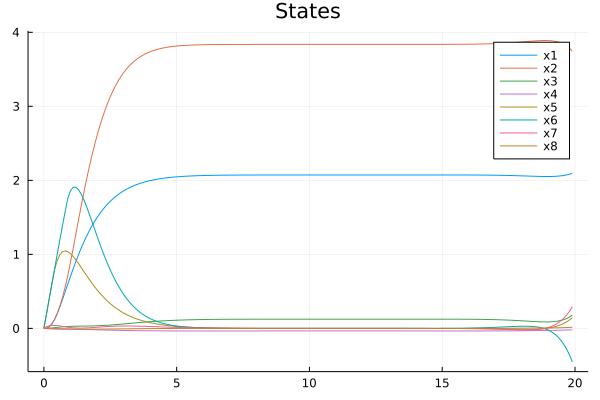

In [41]:
using Plots
tspan = 0 : ∆T : (K-1)*∆T
plot(tspan, x_sol', label=["x1" "x2" "x3" "x4" "x5" "x6" "x7" "x8"], title="States") 

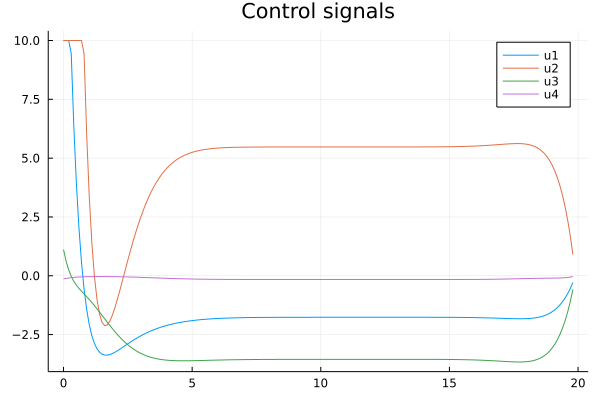

In [42]:
plot(tspan[1:end-1], u_sol', label=["u1" "u2" "u3" "u4"], title="Control signals") 